In [279]:
import torch
from torch import Tensor
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F

import pickle 
import json

import dlc_bci as bci
from helpers import *

import numpy as np

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['image.cmap'] = 'viridis'
import matplotlib.pyplot as plt
import seaborn as sns

torch.manual_seed(1)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Importing the data

In [90]:
# Subset of data sampled at 100Hz
train_input , train_target = bci.load(root = './data_bci')
print("Train input :", str(type(train_input)), train_input.size()) 
print("Train target :", str(type(train_target)), train_target.size())
test_input , test_target = bci.load(root = './data_bci', train = False)
print("Test input :", str(type(test_input)), test_input.size()) 
print("Test target :", str(type(test_target)), test_target.size())

Train input : <class 'torch.FloatTensor'> torch.Size([316, 28, 50])
Train target : <class 'torch.LongTensor'> torch.Size([316])
Test input : <class 'torch.FloatTensor'> torch.Size([100, 28, 50])
Test target : <class 'torch.LongTensor'> torch.Size([100])


In [116]:
# Full data sampled at 1Khz
train_input , train_target = bci.load(root = './data_bci', one_khz = True)
print("Train input :", str(type(train_input)), train_input.size()) 
print("Train target :", str(type(train_target)), train_target.size())
test_input , test_target = bci.load(root = './data_bci', train = False, one_khz = True)
print("Test input :", str(type(test_input)), test_input.size()) 
print("Test target :", str(type(test_target)), test_target.size())

Train input : <class 'torch.FloatTensor'> torch.Size([316, 28, 500])
Train target : <class 'torch.LongTensor'> torch.Size([316])
Test input : <class 'torch.FloatTensor'> torch.Size([100, 28, 500])
Test target : <class 'torch.LongTensor'> torch.Size([100])


In [91]:
train_input[0]


  41.8000   44.8000   47.1000  ...    69.8000   72.6000   76.1000
 -10.3000   -5.9000   -3.3000  ...    12.6000   24.0000   26.5000
  38.1000   25.2000   46.0000  ...    45.1000   74.1000   64.8000
             ...                ⋱                ...             
   7.9000   11.2000   14.3000  ...    32.7000   43.4000   45.5000
  19.2000   33.6000   33.8000  ...    46.7000   53.7000   43.4000
  -0.4000   12.7000   12.0000  ...    30.7000   40.6000   33.1000
[torch.FloatTensor of size 28x50]

In [83]:
train_target


 0
 1
 0
 1
 0
 1
 0
 1
 0
 0
 1
 1
 0
 0
 1
 1
 1
 0
 0
 1
 0
 0
 1
 0
 1
 0
 0
 0
 0
 0
 0
 0
 1
 1
 1
 1
 1
 1
 0
 1
 0
 1
 0
 0
 1
 0
 1
 1
 0
 1
 1
 0
 0
 1
 0
 0
 1
 0
 1
 0
 1
 0
 0
 1
 0
 0
 0
 0
 0
 1
 0
 1
 0
 0
 0
 0
 0
 1
 1
 1
 0
 1
 0
 1
 1
 1
 1
 1
 1
 1
 1
 1
 0
 0
 0
 0
 1
 1
 1
 0
 1
 1
 1
 0
 1
 0
 1
 1
 1
 0
 1
 0
 1
 0
 0
 0
 1
 0
 0
 1
 1
 1
 1
 0
 1
 1
 0
 0
 1
 1
 1
 1
 1
 0
 0
 0
 0
 1
 1
 0
 1
 1
 1
 1
 1
 1
 1
 0
 0
 0
 1
 1
 0
 0
 1
 1
 0
 0
 0
 0
 0
 1
 1
 1
 1
 1
 1
 0
 1
 0
 1
 1
 0
 1
 0
 0
 1
 1
 1
 0
 0
 1
 0
 0
 0
 0
 0
 1
 1
 0
 0
 0
 0
 1
 0
 0
 0
 1
 0
 0
 1
 0
 0
 0
 1
 1
 1
 0
 0
 0
 1
 1
 1
 0
 0
 0
 1
 0
 1
 1
 1
 1
 1
 1
 1
 0
 1
 0
 0
 0
 1
 0
 1
 1
 1
 0
 1
 1
 0
 0
 0
 1
 1
 0
 1
 1
 0
 1
 1
 1
 1
 1
 0
 1
 0
 1
 0
 0
 0
 0
 0
 0
 1
 1
 1
 0
 1
 1
 1
 0
 1
 0
 0
 1
 1
 0
 0
 1
 0
 0
 1
 0
 0
 0
 1
 0
 0
 1
 1
 0
 0
 1
 1
 1
 0
 1
 0
 1
 1
 1
 0
 1
 1
 0
 1
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
[torch.LongTensor of size 316]

### Preprocessing the data

In [117]:
# normalize mean to 0
train_input.sub_(train_input.mean())
test_input.sub_(test_input.mean())

# normalize variance to 1
train_input.div_(train_input.std())
test_input.div_(test_input.std())

print('done')

done


In [118]:
seq = []
for i in range(10):
    seq.append(train_input[:,:,i::10])
train_input = torch.cat(seq)

In [119]:
train_target = torch.cat([train_target]*10)

In [120]:
seq = []
for i in range(10):
    seq.append(test_input[:,:,i::10])
test_input = torch.cat(seq)

In [121]:
test_target = torch.cat([test_target]*10)

## Linear Regression

In [156]:
from sklearn.linear_model import LinearRegression

In [157]:
linear_reg = LinearRegression()

In [158]:
linear_reg.fit(train_input.view(train_input.size(0),-1),train_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [174]:
linear_pred_train = discrete_predictions(torch.FloatTensor(linear_reg.predict(train_input.view(train_input.size(0),-1))))

In [175]:
print(100*((torch.LongTensor(linear_pred_train) - train_target).abs().sum()/train_input.size(0)),"% train error")

0.0 % train error


In [176]:
linear_pred_test = discrete_predictions(torch.FloatTensor(linear_reg.predict(test_input.view(test_input.size(0),-1))))

In [177]:
print(100*((torch.LongTensor(linear_pred_test) - test_target).abs().sum()/test_input.size(0)),"% test error")

27.0 % test error


## Logistic Regression

In [149]:
from sklearn.linear_model import LogisticRegression

In [150]:
logistic_reg = LogisticRegression()

In [151]:
logistic_reg.fit(train_input.view(train_input.size(0),-1),train_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [152]:
logistic_pred_train = logistic_reg.predict(train_input.view(train_input.size(0),-1))

In [153]:
print(100*((torch.LongTensor(logistic_pred_train) - train_target).abs().sum()/train_input.size(0)),"% train error")

0.0 % train error


In [154]:
logistic_pred_test = logistic_reg.predict(test_input.view(test_input.size(0),-1))

In [155]:
print(100*((torch.LongTensor(logistic_pred_test) - test_target).abs().sum()/test_input.size(0)),"% test error")

28.000000000000004 % test error


## Neural Networks

In [10]:
#convert targets to one hot labels
#train_target = convert_to_one_hot_labels(train_input, train_target)
#test_target = convert_to_one_hot_labels(test_input, test_target)

### Basic MLP

In [97]:
MLP_big = nn.Sequential(
        nn.Linear(14000, 1400),
        nn.Tanh(),
        nn.Linear(1400, 280),
        nn.Tanh(),
        nn.Linear(280, 28),
        nn.Tanh(),
        nn.Linear(28, 2)
    )

In [4]:
MLP = nn.Sequential(
        nn.Linear(50, 280),
        nn.Tanh(),
        nn.Linear(280, 140),
        nn.Tanh(),
        nn.Linear(140, 28),
        nn.Tanh(),
        nn.Linear(28, 2)
    )

In [6]:
train_model(MLP, Variable(train_input.view(-1, 1, 28, 50)), Variable(train_target), 4)

RuntimeError: invalid argument 3: only batches of spatial targets supported (3D tensors) but got targets of dimension: 1 at /Users/soumith/code/builder/wheel/pytorch-src/torch/lib/THNN/generic/SpatialClassNLLCriterion.c:60

In [130]:
train_model(MLP, Variable(train_input.view(train_input.size(0),-1)), Variable(train_target), 4)

Epoch 0 loss = 55.861808478832245
Epoch 1 loss = 54.59076404571533
Epoch 2 loss = 53.797380566596985
Epoch 3 loss = 53.191094636917114
Epoch 4 loss = 52.66807159781456
Epoch 5 loss = 52.18098449707031
Epoch 6 loss = 51.69751679897308
Epoch 7 loss = 51.194580405950546
Epoch 8 loss = 50.65688365697861
Epoch 9 loss = 50.074628949165344
Epoch 10 loss = 49.44200122356415
Epoch 11 loss = 48.756370306015015
Epoch 12 loss = 48.019282549619675
Epoch 13 loss = 47.23957505822182
Epoch 14 loss = 46.418880090117455
Epoch 15 loss = 45.549498587846756
Epoch 16 loss = 44.65137520432472
Epoch 17 loss = 43.72418200969696
Epoch 18 loss = 42.76705865561962
Epoch 19 loss = 41.78091523051262
Epoch 20 loss = 40.76593078672886
Epoch 21 loss = 39.72083881497383
Epoch 22 loss = 38.644645400345325
Epoch 23 loss = 37.53784937411547
Epoch 24 loss = 36.39436551183462
Epoch 25 loss = 35.19167825952172
Epoch 26 loss = 33.98767836764455
Epoch 27 loss = 32.73168759420514
Epoch 28 loss = 31.445499220862985
Epoch 29 loss

In [131]:
train_error_mlp = compute_nb_errors(MLP, Variable(test_input.view(test_input.size(0),-1)), Variable(train_target), 4)
print(100*(train_error_mlp/train_input.size(0)),'% training error')

16.455696202531644 % training error


In [132]:
test_error_mlp = compute_nb_errors(MLP, Variable(test_input.view(test_input.size(0),-1)), Variable(test_target), 4)
print(100*(test_error_mlp/test_input.size(0)),'% test error')

28.999999999999996 % test error


### Basic CNN

In [129]:
class Basic_CNN(nn.Module):
    def __init__(self):
        super(Basic_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(640, 2)

    def forward(self, x):
        x = F.tanh(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        x = F.tanh(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.tanh(self.fc1(x.view(-1, 640)))
        return x

In [132]:
cnn = Basic_CNN()

In [133]:
train_model(cnn, Variable(train_input.view(-1, 1, 28, 50)), Variable(train_target), 40)

Epoch 0 loss = 54.498005986213684
Epoch 1 loss = 53.519576370716095
Epoch 2 loss = 52.730925261974335
Epoch 3 loss = 52.011470079422
Epoch 4 loss = 51.306885719299316
Epoch 5 loss = 50.57355135679245
Epoch 6 loss = 49.77597540616989
Epoch 7 loss = 48.90287631750107
Epoch 8 loss = 47.96535176038742
Epoch 9 loss = 46.977213621139526
Epoch 10 loss = 45.9560324549675
Epoch 11 loss = 44.91541266441345
Epoch 12 loss = 43.863889276981354
Epoch 13 loss = 42.80109569430351
Epoch 14 loss = 41.72726050019264
Epoch 15 loss = 40.64559432864189
Epoch 16 loss = 39.55902707576752
Epoch 17 loss = 38.47445222735405
Epoch 18 loss = 37.40180164575577
Epoch 19 loss = 36.34577456116676
Epoch 20 loss = 35.31309676170349
Epoch 21 loss = 34.30517861247063
Epoch 22 loss = 33.31542217731476
Epoch 23 loss = 32.36064922809601
Epoch 24 loss = 31.455952614545822
Epoch 25 loss = 30.621112316846848
Epoch 26 loss = 29.83599954843521
Epoch 27 loss = 29.091609865427017
Epoch 28 loss = 28.385593682527542
Epoch 29 loss = 2

In [134]:
train_error_cnn = compute_nb_errors(cnn, Variable(train_input.view(-1, 1, 28, 50)), Variable(train_target), 4)
print(100*(train_error_cnn/train_input.size(0)),'% training error')

0.31645569620253167 % training error


In [135]:
test_error_cnn = compute_nb_errors(cnn, Variable(test_input.view(-1, 1, 28, 50)), Variable(test_target), 4)
print(100*(test_error_cnn/test_input.size(0)),'% test error')

32.7 % test error


### CNN w 1D filters

v1:

In [186]:
class CNN_1D_conv(nn.Module):
    def __init__(self):
        super(CNN_1D_conv, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(1,5))
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(1,3))
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(1,5))
        self.fc1 = nn.Linear(896*2, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.tanh(F.max_pool2d(self.conv1(x), kernel_size=(1,2), stride=(1,2)))
        x = F.tanh(F.max_pool2d(self.conv2(x), kernel_size=(1,3), stride=(1,3)))
        x = F.tanh(F.max_pool2d(self.conv3(x), kernel_size=(1,3), stride=(1,3)))
        x = F.tanh(self.fc1(x.view(-1, 896*2)))
        x = self.fc2(x)
        return x

In [188]:
train_model(cnn2, Variable(train_input.view(-1, 1, 28, 50)), Variable(train_target), 4)

Epoch 0 loss = 55.29474902153015
Epoch 1 loss = 55.05597680807114
Epoch 2 loss = 54.855808675289154
Epoch 3 loss = 54.682802975177765
Epoch 4 loss = 54.524170219898224
Epoch 5 loss = 54.372238516807556
Epoch 6 loss = 54.2225626707077
Epoch 7 loss = 54.07223069667816
Epoch 8 loss = 53.92045372724533
Epoch 9 loss = 53.7664595246315
Epoch 10 loss = 53.6088582277298
Epoch 11 loss = 53.44771748781204
Epoch 12 loss = 53.28130882978439
Epoch 13 loss = 53.10787773132324
Epoch 14 loss = 52.924775540828705
Epoch 15 loss = 52.73032104969025
Epoch 16 loss = 52.52050358057022
Epoch 17 loss = 52.2923142015934
Epoch 18 loss = 52.04249811172485
Epoch 19 loss = 51.76665839552879
Epoch 20 loss = 51.46092280745506
Epoch 21 loss = 51.12171161174774
Epoch 22 loss = 50.74609687924385
Epoch 23 loss = 50.327125549316406
Epoch 24 loss = 49.860064417123795
Epoch 25 loss = 49.33736914396286
Epoch 26 loss = 48.7524134516716
Epoch 27 loss = 48.09661191701889
Epoch 28 loss = 47.363799035549164
Epoch 29 loss = 46.54

In [189]:
train_error_cnn2 = compute_nb_errors(cnn2, Variable(train_input.view(-1, 1, 28, 50)), Variable(train_target), 4)
print(100*(train_error_cnn2/train_input.size(0)),'% training error')

0.0 % training error


In [190]:
test_error_cnn2 = compute_nb_errors(cnn2, Variable(test_input.view(-1, 1, 28, 50)), Variable(test_target), 4)
print(100*(test_error_cnn2/test_input.size(0)),'% test error')

23.0 % test error


v2 :

In [151]:
class CNN_1D(nn.Module):
    def __init__(self):
        super(CNN_1D, self).__init__()
        self.conv1 = nn.Conv1d(28, 56, kernel_size=5)
        self.conv2 = nn.Conv1d(56, 112, kernel_size=3)
        self.conv3 = nn.Conv1d(112, 112, kernel_size=5)
        #self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(112, 56)
        self.fc2 = nn.Linear(56, 2)

    def forward(self, x):
        x = F.tanh(F.max_pool1d(self.conv1(x), kernel_size=2, stride=2))
        x = F.tanh(F.max_pool1d(self.conv2(x), kernel_size=3, stride=3))
        x = F.tanh(F.max_pool1d(self.conv3(x), kernel_size=3, stride=3))
        #x = self.dropout(x)
        x = F.tanh(self.fc1(x.view(-1, 112)))
        x = self.fc2(x)
        return x

In [161]:
cnn4 = CNN_1D()
train_model(cnn4, Variable(train_input), Variable(train_target), 40, nb_epochs=120, learning_rate=0.005)

Epoch 0 loss = 54.80717808008194
Epoch 1 loss = 54.70321995019913
Epoch 2 loss = 54.62144333124161
Epoch 3 loss = 54.54609006643295
Epoch 4 loss = 54.47215002775192
Epoch 5 loss = 54.397279500961304
Epoch 6 loss = 54.31979596614838
Epoch 7 loss = 54.23857867717743
Epoch 8 loss = 54.152719497680664
Epoch 9 loss = 54.06127589941025
Epoch 10 loss = 53.963149666786194
Epoch 11 loss = 53.85764080286026
Epoch 12 loss = 53.74411725997925
Epoch 13 loss = 53.621960520744324
Epoch 14 loss = 53.490806221961975
Epoch 15 loss = 53.3504199385643
Epoch 16 loss = 53.20103591680527
Epoch 17 loss = 53.042898178100586
Epoch 18 loss = 52.87592488527298
Epoch 19 loss = 52.69968330860138
Epoch 20 loss = 52.512857258319855
Epoch 21 loss = 52.313249707221985
Epoch 22 loss = 52.09775102138519
Epoch 23 loss = 51.862221360206604
Epoch 24 loss = 51.600734174251556
Epoch 25 loss = 51.30662363767624
Epoch 26 loss = 50.97217923402786
Epoch 27 loss = 50.58827191591263
Epoch 28 loss = 50.145546674728394
Epoch 29 loss 

In [162]:
train_error_cnn4 = compute_nb_errors(cnn4, Variable(train_input), Variable(train_target), 40)
print(100*(train_error_cnn4/train_input.size(0)),'% training error')

0.09493670886075949 % training error


In [163]:
test_error_cnn4 = compute_nb_errors(cnn4, Variable(test_input), Variable(test_target), 40)
print(100*(1-(test_error_cnn4/test_input.size(0))),'% test accuracy')

73.5 % test accuracy


### previous + dropout

In [195]:
class CNN_dropout(nn.Module):
    def __init__(self):
        super(CNN_dropout, self).__init__()
        self.conv1 = nn.Conv1d(28, 56, kernel_size=5)
        self.conv2 = nn.Conv1d(56, 112, kernel_size=3)
        self.conv3 = nn.Conv1d(112, 112, kernel_size=5)
        self.fc1 = nn.Linear(112, 56)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(56, 2)

    def forward(self, x):
        x = F.tanh(F.max_pool1d(self.conv1(x), kernel_size=2, stride=2))
        x = F.tanh(F.max_pool1d(self.conv2(x), kernel_size=3, stride=3))
        x = F.tanh(F.max_pool1d(self.conv3(x), kernel_size=3, stride=3))
        x = self.fc1(x.view(-1, 112))
        x = self.dropout(x)
        x = self.fc2(F.tanh(x))
        return x

In [171]:
cnn3 = CNN_dropout()
train_model(cnn3, Variable(train_input), Variable(train_target), 20, nb_epochs=140, learning_rate=0.005)

Epoch 0 loss = 54.81373769044876
Epoch 1 loss = 54.668377578258514
Epoch 2 loss = 54.62901657819748
Epoch 3 loss = 54.515659153461456
Epoch 4 loss = 54.52439606189728
Epoch 5 loss = 54.237469136714935
Epoch 6 loss = 54.175403356552124
Epoch 7 loss = 53.991609275341034
Epoch 8 loss = 54.01105797290802
Epoch 9 loss = 53.85242795944214
Epoch 10 loss = 53.63609594106674
Epoch 11 loss = 53.5738622546196
Epoch 12 loss = 53.413128554821014
Epoch 13 loss = 53.16618990898132
Epoch 14 loss = 53.06097322702408
Epoch 15 loss = 52.77126497030258
Epoch 16 loss = 52.46380579471588
Epoch 17 loss = 52.251897275447845
Epoch 18 loss = 52.10526090860367
Epoch 19 loss = 51.59744983911514
Epoch 20 loss = 51.36152005195618
Epoch 21 loss = 51.03365182876587
Epoch 22 loss = 50.29474097490311
Epoch 23 loss = 49.955027401447296
Epoch 24 loss = 49.26357388496399
Epoch 25 loss = 48.516477048397064
Epoch 26 loss = 47.920060098171234
Epoch 27 loss = 47.34015101194382
Epoch 28 loss = 46.479187071323395
Epoch 29 loss 

In [173]:
train_error_cnn3 = compute_nb_errors(cnn3, Variable(train_input), Variable(train_target), 40)
print(100*(train_error_cnn3/train_input.size(0)),'% training error')

0.0 % training error


In [176]:
test_error_cnn3 = compute_nb_errors(cnn3, Variable(test_input), Variable(test_target))
print(100*(1-(test_error_cnn3/test_input.size(0))),'% test accuracy')

75.1 % test accuracy


## Grid search

In [190]:
batch_sizes = [20, 40]
learning_rates = [0.01, 0.0075, 0.005, 0.0025, 0.001]
nb_epochs = [100, 110, 120, 130, 140, 150]

In [191]:
print("WITHOUT DROPOUT")
print("")
no_dropout = []
for b_size in batch_sizes:
    print("Batch size", b_size)
    print("="*14)
    epoch_acc = []
    for e in nb_epochs: 
        print("    ", e,"epochs")
        print("  ", "-"*15)
        lr_acc =[]
        for lr in learning_rates:
            print("        Learning rate", lr, ":")
            model = CNN_1D()
            train_model(model, Variable(train_input), Variable(train_target), b_size, nb_epochs=e, learning_rate=lr)
            test_error = compute_nb_errors(model, Variable(test_input), Variable(test_target))
            lr_acc.append(100*(1-(test_error/test_input.size(0))))
        epoch_acc.append(lr_acc)
        print("      For", e, "epochs :", lr_acc)
    print("  With minibatches of size", b_size, ":", epoch_acc)
    no_dropout.append(epoch_acc)
print("Done.")

WITHOUT DROPOUT
Batch size 20
     100 epochs
   ---------------
        Learning rate 0.01 :
            Epoch 0 loss = 109.26239770650864
            Epoch 10 loss = 87.35559633374214
            Epoch 20 loss = 29.273580979555845
            Epoch 30 loss = 3.4526535307522863
            Epoch 40 loss = 0.8238349893363193
            Epoch 50 loss = 0.36731731047620997
            Epoch 60 loss = 0.22038837501895614
            Epoch 70 loss = 0.1540524371812353
            Epoch 80 loss = 0.11730458836245816
            Epoch 90 loss = 0.09412753221113235
        Learning rate 0.0075 :
            Epoch 0 loss = 109.53126090765
            Epoch 10 loss = 98.59997701644897
            Epoch 20 loss = 60.63624921441078
            Epoch 30 loss = 18.417776821181178
            Epoch 40 loss = 3.300629359902814
            Epoch 50 loss = 1.032872662995942
            Epoch 60 loss = 0.49333338884753175
            Epoch 70 loss = 0.29543064860627055
            Epoch 80 loss = 0.204

            Epoch 70 loss = 96.2366686463356
            Epoch 80 loss = 88.43559655547142
            Epoch 90 loss = 81.34048029780388
            Epoch 100 loss = 75.77934151887894
            Epoch 110 loss = 70.32732009887695
      For 120 epochs : [72.7, 73.8, 72.1, 76.3, 70.7]
     130 epochs
   ---------------
        Learning rate 0.01 :
            Epoch 0 loss = 109.41912245750427
            Epoch 10 loss = 89.2061228454113
            Epoch 20 loss = 29.748647063970566
            Epoch 30 loss = 3.4543337021023035
            Epoch 40 loss = 0.8478749920614064
            Epoch 50 loss = 0.35630048502935097
            Epoch 60 loss = 0.20666124668787234
            Epoch 70 loss = 0.14177108833973762
            Epoch 80 loss = 0.10677547605882864
            Epoch 90 loss = 0.08511241612723097
            Epoch 100 loss = 0.07045971160550835
            Epoch 110 loss = 0.05992539228464011
            Epoch 120 loss = 0.05200195697398158
        Learning rate 0.0075 :
 

            Epoch 60 loss = 0.45351790863787755
            Epoch 70 loss = 0.28474878732231446
            Epoch 80 loss = 0.2026986279815901
            Epoch 90 loss = 0.15548856518580578
            Epoch 100 loss = 0.12516894747386687
            Epoch 110 loss = 0.10419405820721295
            Epoch 120 loss = 0.0889097872786806
            Epoch 130 loss = 0.07731400805641897
            Epoch 140 loss = 0.06822999032010557
        Learning rate 0.005 :
            Epoch 0 loss = 109.05028355121613
            Epoch 10 loss = 99.27646064758301
            Epoch 20 loss = 74.3832175731659
            Epoch 30 loss = 39.40646857023239
            Epoch 40 loss = 13.405586401000619
            Epoch 50 loss = 3.786835875827819
            Epoch 60 loss = 1.5202864434104413
            Epoch 70 loss = 0.7924504596740007
            Epoch 80 loss = 0.4942314198706299
            Epoch 90 loss = 0.34665462566772476
            Epoch 100 loss = 0.2624839688069187
            Epoch 110 

            Epoch 90 loss = 52.04386931657791
            Epoch 100 loss = 51.41359078884125
      For 110 epochs : [76.0, 73.3, 76.0, 71.30000000000001, 50.4]
     120 epochs
   ---------------
        Learning rate 0.01 :
            Epoch 0 loss = 54.97470462322235
            Epoch 10 loss = 52.39678418636322
            Epoch 20 loss = 42.784855753183365
            Epoch 30 loss = 28.444043949246407
            Epoch 40 loss = 13.125697661191225
            Epoch 50 loss = 3.6763510555028915
            Epoch 60 loss = 1.1308350977487862
            Epoch 70 loss = 0.51169493352063
            Epoch 80 loss = 0.30108465324155986
            Epoch 90 loss = 0.2061525417957455
            Epoch 100 loss = 0.15410713135497645
            Epoch 110 loss = 0.121761717076879
        Learning rate 0.0075 :
            Epoch 0 loss = 54.79721987247467
            Epoch 10 loss = 52.45394325256348
            Epoch 20 loss = 43.68911558389664
            Epoch 30 loss = 33.635463923215866

            Epoch 60 loss = 21.77935630083084
            Epoch 70 loss = 15.155114434659481
            Epoch 80 loss = 9.387870378792286
            Epoch 90 loss = 4.896859247237444
            Epoch 100 loss = 2.426760943606496
            Epoch 110 loss = 1.3154400973580778
            Epoch 120 loss = 0.7958167036995292
            Epoch 130 loss = 0.5358434673398733
        Learning rate 0.0025 :
            Epoch 0 loss = 54.71114772558212
            Epoch 10 loss = 54.425776302814484
            Epoch 20 loss = 54.0970014333725
            Epoch 30 loss = 53.601517260074615
            Epoch 40 loss = 52.83477580547333
            Epoch 50 loss = 51.60841566324234
            Epoch 60 loss = 49.16741096973419
            Epoch 70 loss = 44.63211044669151
            Epoch 80 loss = 40.15624663233757
            Epoch 90 loss = 36.55785861611366
            Epoch 100 loss = 32.687134593725204
            Epoch 110 loss = 28.083193972706795
            Epoch 120 loss = 23.11968

In [192]:
normal_results = {"batch_sizes":batch_sizes, "learning_rates":learning_rates, "nb_epochs":nb_epochs, "results":no_dropout}

In [193]:
json.dump(normal_results,open('results_no_dropout.json','w'))

In [194]:
json.load(open('results_no_dropout.json','r'))

{'batch_sizes': [20, 40],
 'learning_rates': [0.01, 0.0075, 0.005, 0.0025, 0.001],
 'nb_epochs': [100, 110, 120, 130, 140, 150],
 'results': [[[76.8, 73.8, 74.7, 73.4, 69.8],
   [73.8, 72.2, 71.6, 71.7, 71.50000000000001],
   [72.7, 73.8, 72.1, 76.3, 70.7],
   [73.6, 73.5, 76.7, 74.5, 70.30000000000001],
   [75.8, 72.1, 69.9, 69.6, 73.3],
   [75.8, 71.89999999999999, 72.1, 73.6, 69.0]],
  [[73.8, 74.8, 73.5, 72.1, 48.8],
   [76.0, 73.3, 76.0, 71.30000000000001, 50.4],
   [72.6, 74.0, 76.9, 68.6, 47.699999999999996],
   [72.7, 74.4, 73.9, 73.2, 57.3],
   [73.8, 71.6, 73.9, 73.4, 60.9],
   [74.4, 74.9, 73.9, 74.1, 62.4]]]}

In [250]:
print("WITH DROPOUT")
print("")
with_dropout = []
for b_size in batch_sizes:
    print("Batch size", b_size)
    print("="*14)
    lr_acc = []
    for lr in learning_rates: 
        print("    Learning rate", lr, ":")
        print("  ", "-"*22)
        epoch_acc = []
        model = CNN_dropout()
        train_model(model, Variable(train_input), Variable(train_target), b_size, learning_rate=lr)
        test_error = compute_nb_errors(model, Variable(test_input), Variable(test_target))
        epoch_acc.append(100*(1-(test_error/test_input.size(0))))
        for i in range(5):
            train_model(model, Variable(train_input), Variable(train_target), b_size, nb_epochs=10, learning_rate=lr)
            test_error = compute_nb_errors(model, Variable(test_input), Variable(test_target))
            epoch_acc.append(100*(1-(test_error/test_input.size(0))))
        lr_acc.append(epoch_acc)
        print("      For a learning rate of", lr, ":", epoch_acc)
    print("  With minibatches of size", b_size, ":", lr_acc)
    with_dropout.append(lr_acc)
print("Done.")

WITH DROPOUT

Batch size 20
    Learning rate 0.01 :
   ----------------------
            Epoch 1 loss = 109.56861990690231
            Epoch 10 loss = 97.68512445688248
            Epoch 20 loss = 44.219020545482635
            Epoch 30 loss = 5.120638834312558
            Epoch 40 loss = 1.2338459701277316
            Epoch 50 loss = 0.5521879402222112
            Epoch 60 loss = 0.34920062322635204
            Epoch 70 loss = 0.2755592145549599
            Epoch 80 loss = 0.19016350763558876
            Epoch 90 loss = 0.15994437631161418
            Epoch 100 loss = 0.12974347618728643
            Epoch 1 loss = 0.13672240971209249
            Epoch 10 loss = 0.12727110175183043
            Epoch 1 loss = 0.10125427930688602
            Epoch 10 loss = 0.0968204613745911
            Epoch 1 loss = 0.10534073887538398
            Epoch 10 loss = 0.08921499579082592
            Epoch 1 loss = 0.0914028889455949
            Epoch 10 loss = 0.07541410003614146
            Epoch 1 loss

            Epoch 1 loss = 54.91450089216232
            Epoch 10 loss = 54.06467169523239
            Epoch 20 loss = 52.71694880723953
            Epoch 30 loss = 49.13769429922104
            Epoch 40 loss = 41.97347775101662
            Epoch 50 loss = 35.981355518102646
            Epoch 60 loss = 27.21285429596901
            Epoch 70 loss = 19.208084240555763
            Epoch 80 loss = 12.621800161898136
            Epoch 90 loss = 7.263875424861908
            Epoch 100 loss = 3.752448473125696
            Epoch 1 loss = 3.4975507725030184
            Epoch 10 loss = 2.073324886150658
            Epoch 1 loss = 1.9309103712439537
            Epoch 10 loss = 1.257086329627782
            Epoch 1 loss = 1.1806313153356314
            Epoch 10 loss = 0.8548443848267198
            Epoch 1 loss = 0.8137015693355352
            Epoch 10 loss = 0.5689654373563826
            Epoch 1 loss = 0.5970331872813404
            Epoch 10 loss = 0.47645941376686096
      For a learning rate o

In [251]:
dropout_results = {"batch_sizes":batch_sizes, "learning_rates":learning_rates, "nb_epochs":nb_epochs, "results":with_dropout}

In [252]:
json.dump(dropout_results,open('results_with_dropout.json','w'))

In [253]:
json.load(open('results_with_dropout.json','r'))

{'batch_sizes': [20, 40],
 'learning_rates': [0.01, 0.0075, 0.005, 0.0025, 0.001],
 'nb_epochs': [100, 110, 120, 130, 140, 150],
 'results': [[[73.0, 73.1, 73.5, 72.3, 72.39999999999999, 73.0],
   [75.2, 75.1, 75.4, 75.4, 75.6, 75.3],
   [73.8, 73.8, 73.5, 73.6, 73.4, 73.7],
   [75.1, 75.5, 75.4, 74.8, 74.1, 73.1],
   [67.30000000000001,
    70.8,
    70.6,
    72.8,
    70.30000000000001,
    69.39999999999999]],
  [[73.2, 73.1, 73.1, 72.6, 72.39999999999999, 72.2],
   [76.8, 76.2, 75.9, 75.1, 74.6, 74.7],
   [76.0, 76.3, 76.2, 77.0, 77.0, 76.8],
   [70.7, 70.7, 69.39999999999999, 71.10000000000001, 71.50000000000001, 73.3],
   [50.8, 51.4, 53.6, 56.89999999999999, 57.00000000000001, 60.6]]]}

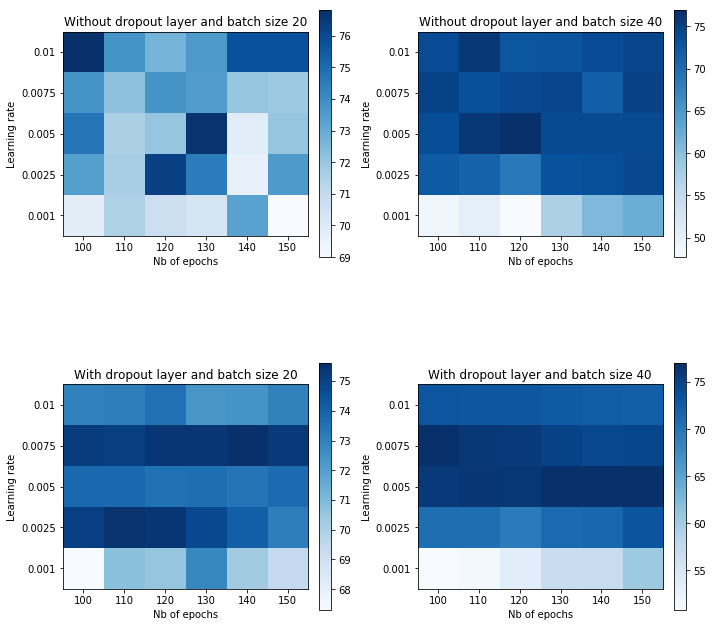

In [281]:
plt.figure(1)

colormap = 'Blues'
normal_xticks = normal_results['nb_epochs']
normal_yticks = normal_results['learning_rates']

plt.subplot(221)
plt.imshow(np.array(normal_results['results'][0]).T, cmap=colormap)
plt.xlabel('Nb of epochs')
plt.ylabel('Learning rate')
plt.xticks(range(len(normal_xticks)), normal_xticks)
plt.yticks(range(len(normal_yticks)), normal_yticks)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Without dropout layer and batch size 20')

plt.subplot(222)
plt.imshow(np.array(normal_results['results'][1]).T, cmap=colormap)
plt.xlabel('Nb of epochs')
plt.ylabel('Learning rate')
plt.xticks(range(len(normal_xticks)), normal_xticks)
plt.yticks(range(len(normal_yticks)), normal_yticks)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Without dropout layer and batch size 40')

dropout_xticks = dropout_results['nb_epochs']
dropout_yticks = dropout_results['learning_rates']

plt.subplot(223)
plt.imshow(dropout_results['results'][0], cmap=colormap)
plt.xlabel('Nb of epochs')
plt.ylabel('Learning rate')
plt.xticks(range(len(dropout_xticks)), dropout_xticks)
plt.yticks(range(len(dropout_yticks)), dropout_yticks)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('With dropout layer and batch size 20')

plt.subplot(224)
plt.imshow(dropout_results['results'][1], cmap=colormap)
plt.xlabel('Nb of epochs')
plt.ylabel('Learning rate')
plt.xticks(range(len(dropout_xticks)), dropout_xticks)
plt.yticks(range(len(dropout_yticks)), dropout_yticks)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('With dropout layer and batch size 40')

plt.tight_layout()
plt.savefig("results_1.png")
plt.show()